In [1]:
import os
import cv2
import time
import copy
import numpy as np
import pandas as pd
import albumentations as album
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms as T
from torchvision.datasets import MNIST
from torchsummary import summary
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from datasets import load_metric
from transformers import SegformerImageProcessor, BertModel, BertConfig
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils import *
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PATH_DATASETS = '/home/morten/Documents/Algorithms-for-Automated-Driving/code/solutions/lane_detection/data_lane_segmentation/'

In [2]:
class_names = ['background', 'left', 'right']

class_rgb_values = [[0,0,0], [1,1,1], [2,2,2]]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'left', 'right']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [3]:
# Useful to shortlist specific classes in datasets with large number of classes
select_classes = ['background', 'left', 'right']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'left', 'right']
Class RGB values:  [[0, 0, 0], [1, 1, 1], [2, 2, 2]]


In [4]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [5]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

In [6]:
class LaneSegmentDataset(Dataset):
    def __init__(self, img_dir, label_dir, list_of_filenames, class_rgb_values=None, augmentation=None, preprocessing=None,):
        super().__init__()
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.list_of_filenames = list_of_filenames
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing


    def __len__(self):
        return len(self.list_of_filenames)

    def __getitem__(self, idx):
        img = cv2.cvtColor(cv2.imread(self.img_dir + self.list_of_filenames[idx] + '.png'), cv2.COLOR_BGR2RGB)
        label = cv2.cvtColor(cv2.imread(self.label_dir + self.list_of_filenames[idx] + '_label.png', cv2.IMREAD_GRAYSCALE), cv2.COLOR_GRAY2RGB)

        # one-hot-encode the mask
        label = one_hot_encode(label, self.class_rgb_values).astype(float)

        if self.augmentation:
            sample = self.augmentation(image=img, mask=label)
            img, label = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=img, mask=label)
            img, label = sample['image'], sample['mask']

        # img = torch.from_numpy(img).float()
        # label = torch.from_numpy(label).float()

        # img = torch.permute(img, (2,0,1))
        # label = torch.permute(label, (2,0,1))


        return img, label

In [7]:
img_dir = PATH_DATASETS + 'train/'
label_dir = PATH_DATASETS + 'train_label/'

name_fit = []
for dirname, _, filenames_fit in os.walk(img_dir):
    for filename_fit in filenames_fit:
        name_fit.append(filename_fit.split('.')[0])
img_fit = pd.DataFrame({'id': name_fit}, index = np.arange(0, len(name_fit)))
lane_train_path, lane_val_path = train_test_split(img_fit['id'].values, test_size=0.2, train_size=0.8, random_state=10)

lane_train_dataset = LaneSegmentDataset(img_dir, label_dir, lane_train_path, class_rgb_values, preprocessing=get_preprocessing(preprocessing_fn=None))
lane_val_dataset = LaneSegmentDataset(img_dir, label_dir, lane_val_path, class_rgb_values, preprocessing=get_preprocessing(preprocessing_fn=None))


test_img_dir = PATH_DATASETS + 'val/'
test_label_dir = PATH_DATASETS + 'val_label/'

name_test = []
for dirname, _, filenames_test in os.walk(test_img_dir):
    for filename_test in filenames_test:
        name_test.append(filename_test.split('.')[0])
img_test = pd.DataFrame({'id': name_test}, index =np.arange(0, len(name_test)))
lane_temp, lane_test = train_test_split(img_test['id'].values, test_size=128, train_size=1, random_state=10)

lane_test_dataset = LaneSegmentDataset(test_img_dir, test_label_dir, lane_test, class_rgb_values, preprocessing=get_preprocessing(preprocessing_fn=None))

batch_size = 1
num_workers = 4

train_dataloader = DataLoader(lane_train_dataset, batch_size=batch_size, num_workers=num_workers)
val_dataloader = DataLoader(lane_val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(lane_test_dataset, batch_size=batch_size, num_workers=1)


torch.Size([1, 3, 512, 1024]) torch.Size([1, 3, 512, 1024])
(3, 512, 1024)


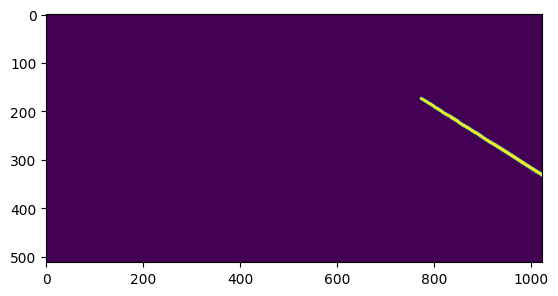

In [8]:
for step, (x,y) in enumerate(train_dataloader):
    if step < 1:
        print(x.shape, y.shape)
        img = x[0,:,:,:]
        img = img.detach().cpu().numpy().astype(int)
        img = np.transpose(img, (1,2,0))
        label = y[0,:,:,:]
        label = label.detach().cpu().numpy().astype(int)
        print(label.shape)
        # np.transpose(label, (1,2,0))
        plt.imshow(label[2])
    else:
        break

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x
    

# Get UNet model
model = UNet()

In [10]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 12

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define loss function
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# define optimizer
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)

In [11]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
%%time


if TRAINING:
    
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    torch.cuda.empty_cache()

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_dataloader)
        valid_logs = valid_epoch.run(val_dataloader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 615/615 [02:12<00:00,  4.64it/s, dice_loss - 1.441, iou_score - 0.009263]
Model saved!

Epoch: 1
valid: 100%|██████████| 615/615 [02:12<00:00,  4.65it/s, dice_loss - 1.363, iou_score - 0.01765]
Model saved!

Epoch: 2
valid: 100%|██████████| 615/615 [02:13<00:00,  4.60it/s, dice_loss - 1.187, iou_score - 0.08096]
Model saved!

Epoch: 3
valid: 100%|██████████| 615/615 [02:13<00:00,  4.62it/s, dice_loss - 0.8179, iou_score - 0.1187]
Model saved!

Epoch: 4
valid: 100%|██████████| 615/615 [02:12<00:00,  4.63it/s, dice_loss - 0.5463, iou_score - 0.1595]
Model saved!

Epoch: 5
valid: 100%|██████████| 615/615 [02:12<00:00,  4.64it/s, dice_loss - 0.6248, iou_score - 0.007311]  

Epoch: 6
valid: 100%|██████████| 615/615 [02:12<00:00,  4.63it/s, dice_loss - 0.313, iou_score - 0.2614] 
Model saved!

Epoch: 7
valid: 100%|██████████| 615/615 [02:12<00:00,  4.64it/s, dice_loss - 0.9933, iou_score - 0.01634]

Epoch: 8
valid: 100%|██████████| 615/615 [02:12<00:00,  4.6

In [12]:
# torch.cuda.empty_cache()
# load best saved model checkpoint from the current run
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
elif os.path.exists('../input/unet-for-building-segmentation-pytorch/best_model.pth'):
    best_model = torch.load('../input/unet-for-building-segmentation-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


torch.Size([1, 3, 512, 1024])


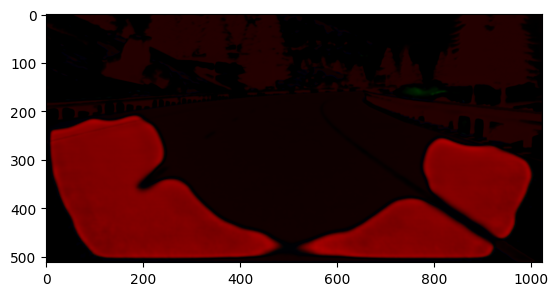

In [13]:
torch.cuda.empty_cache()

for step, (x,y) in enumerate(test_dataloader):
    torch.cuda.empty_cache()
    if step < 1:
        torch.cuda.empty_cache()
        pred = best_model(x.to(DEVICE))
        print(pred.shape)

        output = pred[0,:,:,:]
        output = torch.permute(output, (1,2,0))
        output = output.detach().cpu().numpy()
        output = output/np.amax(output)
        output = np.clip(output, 0, 1)
        plt.imshow(output)
    else:
        break